# Clustering text — features

This notebook compares using different sets of features when clustering text documents. In these examples the clustering algorithm itself is held constant (kmeans clustering was used throughout).

In [1]:
from __future__ import division


import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib  import rcParams
rcParams['figure.figsize']=(15,7)

import ipywidgets as widgets
from ipywidgets import interactive

## Read in the processed data

First read in the data that was retrieved and cleaned in other notebooks. This data consists of written parliamentary questions asked of HM Treasury and were obtained from an API provided by the UK Parliament.

In [2]:
fin_name = "./tokenised.pkl"
df = pd.read_pickle(fin_name)

# Randomly shuffle the data
df = df.sample(frac=1, random_state=40)
df.reset_index(inplace=True, drop=True)
df.head()

,text,tokens,doc_vectors
0,"To ask Mr Chancellor of the Exchequer, what di...","[discuss, financi, conduct, author, introduct,...","[-0.0295013285122, 0.130596501564, 0.037932070..."
1,To ask Her Majesty’s Government what assessmen...,"[majesti, govern, assess, made, case, 50, note...","[-0.0126562437263, 0.00217332167185, 0.0162072..."
2,"To ask Mr Chancellor of the Exchequer, pursuan...","[pursuant, answer, 11, septemb, 2015, question...","[0.00593095702226, -0.024836287443, 0.03737264..."
3,"To ask Mr Chancellor of the Exchequer, with re...","[refer, answer, 28, april, 2016, question, 354...","[0.000982968754245, -0.0674015487162, 0.039356..."
4,"To ask Mr Chancellor of the Exchequer, how man...","[mani, peopl, receiv, corpor, tax, relief, pat...","[0.0340037614471, -0.042533184904, 0.036632773..."


## Create features

The first step is to create the different sets of features. The following are considered:
- TF-IDF vectors.
- TF-IDF vectors whose dimensionality has been reduced using SVD.
- Document vectors created from aggregating pretrained word2vec vectors which were weighted based on IDF.

Note, the document vector generation was done on the cleaing notebook within this project.

### TF-IDF features

*sklearn* is used to create the TF-IDF vectors. The text has already been preprocessed and tokenised so these options need to be turned off.

In [3]:
tfidf = TfidfVectorizer(
            tokenizer = lambda x: x, 
            preprocessor = None, 
            lowercase = False, 
            ngram_range = [1,1],
            max_features = 1500
        )

X_tfidf = tfidf.fit_transform(df['tokens'])

### TF-IDF + SVD features

TF-IDF produces high-dimensional sparce vectors which might not be ideal for clustering. As the number of dimensions grows the distance between points becomes more homogeneous so dense cluster might nolonger appear.

Here truncated SVD is used on the TF-IDF vectors to reduce their dimension to just 100 features. This number was chosen at random and has not been tuned.

In [4]:
reducer = TruncatedSVD(n_components=100)
X_reduce = reducer.fit_transform(X_tfidf)

### Document vectors features

Document vectors were created in a previous notebook so just need to be transferred from the dataframe to a *numpy* array.

In [5]:
X_docvecs = np.array(df['doc_vectors'].tolist())

## Visualising the data

Let's attempt to visulise the data to see whether we can detect any clusterings. Unfortunately the data has a large number of dimensions so cannot be directly visulalised.

There are methods to reduce the dimensionality; however, they might not retain enough information to display clusters that are present (if any are).

First let's project onto two dimenstions using principal component analysis.

In [6]:
pca = PCA(n_components=2)

X2d_tfidf = pca.fit_transform(X_tfidf.todense())
X2d_reduce = pca.fit_transform(X_reduce)
X2d_docvecs = pca.fit_transform(X_docvecs)

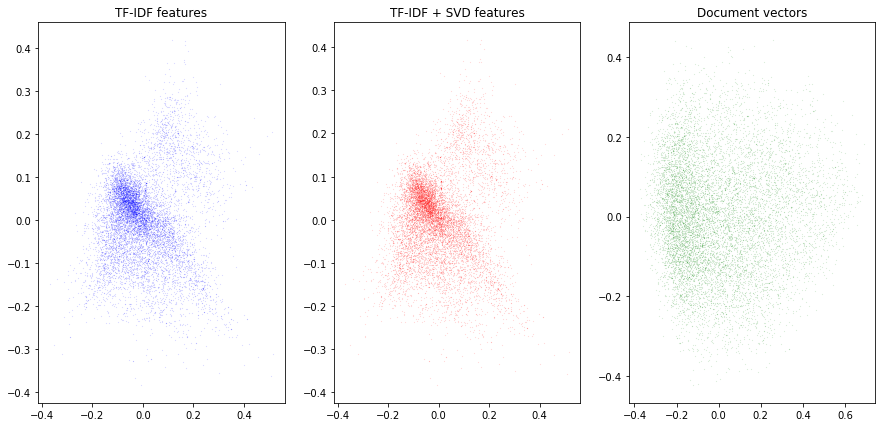

In [7]:
rcParams['lines.markersize']=0.05
rcParams['figure.figsize']=(15,7)

plt.subplot(1, 3, 1)
plt.title("TF-IDF features")
plt.scatter(X2d_tfidf[:,0], X2d_tfidf[:,1], c='b')

plt.subplot(1, 3, 2)
plt.title("TF-IDF + SVD features")
plt.scatter(X2d_reduce[:,0], X2d_reduce[:,1], c='r')

plt.subplot(1, 3, 3)
plt.title("Document vectors")
plt.scatter(X2d_docvecs[:,0], X2d_docvecs[:,1], c='g')

plt.show()

Whilst some areas are more dense than others there are no clear clusters.

Another techique is T-SNE; however, this cannot cope with large volumes of data so here we take a random sample (the dataframe has been shuffled earlier).

In [8]:
size = 500

tsne = TSNE(n_components=2)

Xt_tfidf = tsne.fit_transform(X_tfidf.todense()[0:size,:])
Xt_reduce = tsne.fit_transform(X_reduce[0:size,:])
Xt_docvecs = tsne.fit_transform(X_docvecs[0:size,:])

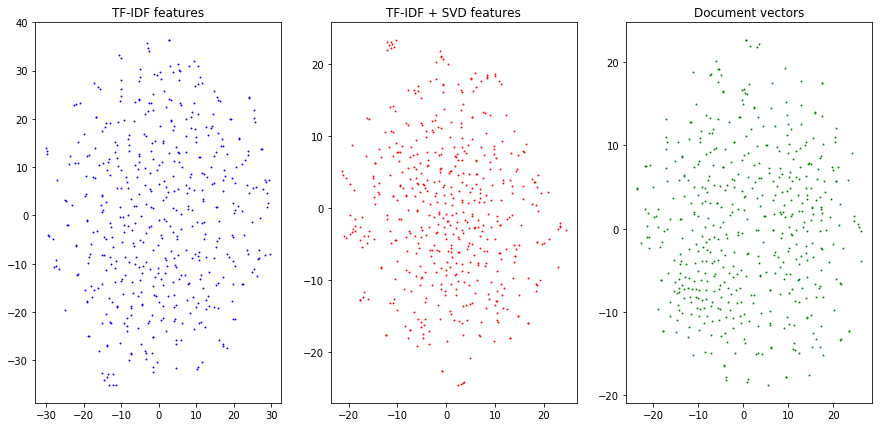

In [9]:
rcParams['lines.markersize']=0.9

plt.subplot(1, 3, 1)
plt.title("TF-IDF features")
plt.scatter(Xt_tfidf[:,0], Xt_tfidf[:,1], c='b')

plt.subplot(1, 3, 2)
plt.title("TF-IDF + SVD features")
plt.scatter(Xt_reduce[:,0], Xt_reduce[:,1], c='r')

plt.subplot(1, 3, 3)
plt.title("Document vectors")
plt.scatter(Xt_docvecs[:,0], Xt_docvecs[:,1], c='g')

plt.show()

The T-SNE algorithm has a number of parameters, the most important being the *perplexity*. Let's create an interative widget to allow you to change this parameter.

This requires the command:

    jupyter nbextension enable --py widgetsnbextension

to have been run on the command line. First define the perplexities that will be explored.

In [10]:
perplexs = [1, 5, 50, 100]

The T-SNE algorithm takes along time to run so we pre-compute the graphs for each of these values.

In [11]:
%%capture
def plot_tsne(perplex):
    size = 500

    tsne = TSNE(n_components=2, perplexity=5)

    Xt_tfidf = tsne.fit_transform(X_tfidf.todense()[0:size,:])
    Xt_reduce = tsne.fit_transform(X_reduce[0:size,:])
    Xt_docvecs = tsne.fit_transform(X_docvecs[0:size,:])
    rcParams['lines.markersize']=0.9

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    
    fig.set_figheight(7)
    fig.set_figwidth(15)
    
    ax1.set_title("TF-IDF features")
    ax1.scatter(Xt_tfidf[:,0], Xt_tfidf[:,1], c='b')

    ax2.set_title("TF-IDF + SVD features")
    ax2.scatter(Xt_reduce[:,0], Xt_reduce[:,1], c='r')

    ax3.set_title("Document vectors")
    ax3.scatter(Xt_docvecs[:,0], Xt_docvecs[:,1], c='g')

    return fig

tsne_figures = {}
for perplex in perplexs:
    tsne_figures[perplex] = plot_tsne(perplex)



A radio button is then created that allows the correct graph to be selected.

In [12]:
%matplotlib inline

w = widgets.RadioButtons(
    options = perplexs,
    value = 5,
    description = "Perplexity:",
    disabled = False
    )

interactive(lambda perplex: display(tsne_figures[perplex]), perplex=w)
# jupyter nbextension enable --py widgetsnbextension

interactive(children=(RadioButtons(description=u'Perplexity:', index=1, options=(1, 5, 50, 100), value=5), Output()), _dom_classes=('widget-interact',))

## Comparing clustering using these features

Many clustering algorithms have the number of clusters as a free parameter that needs to be tuned (this is the case with the kmeans algorithm used here). One way of determining this parameter is to try a series of different values and sees which one maximised the silhouette score. Let's do this for our three sets of features.

In [13]:
df_scores = pd.DataFrame(columns=['tfidf', 'tfidf_svd', 'docvecs'])
cluster_nums = [2, 5, 10, 100, 500]

def cluster_score(X, clusterer):
    cluster_labels = clusterer.fit_predict(X)
    return silhouette_score(X, cluster_labels)

for indx, num in enumerate(cluster_nums):
    print "  Working on clusters of size:", num
    clusterer = KMeans(n_clusters=num)
    df_scores.loc[indx] = [cluster_score(X_tfidf, clusterer),
                           cluster_score(X_reduce, clusterer),
                           cluster_score(X_docvecs, clusterer)]

print ""
df_scores

  Working on clusters of size: 2
  Working on clusters of size: 5
  Working on clusters of size: 10
  Working on clusters of size: 100
  Working on clusters of size: 500



,tfidf,tfidf_svd,docvecs
0,0.008125,0.042583,0.051816
1,0.010537,0.037357,0.031555
2,0.013667,0.042115,0.012924
3,0.032868,0.062303,0.015257
4,0.052897,0.058567,0.029042


## Exploring the two clusters

Document vector features suggest two clusters. Let's look at this further.

### Visualise the clusters

Let's visualise the clusters, first extract the cluster labels.

In [14]:
clusterer = KMeans(n_clusters=2)
cluster_labels = clusterer.fit_predict(X_docvecs)

Then plot using PCA as before.

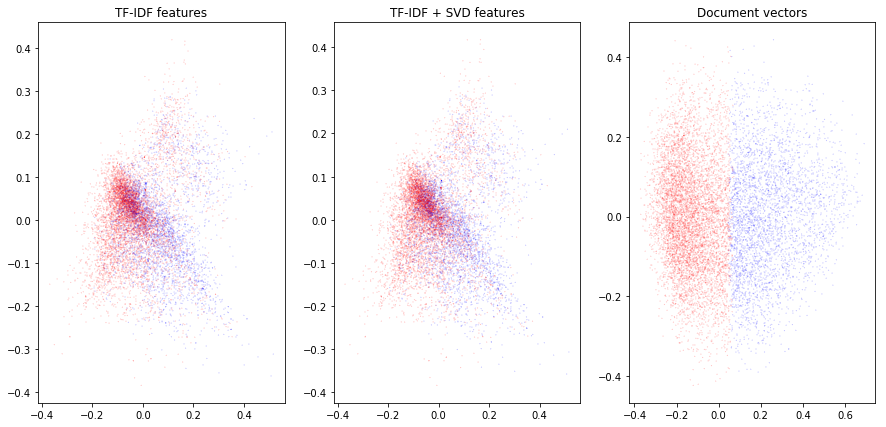

In [15]:
cluster_colours = ['b' if label==1 else 'r' for label in cluster_labels]

rcParams['lines.markersize']=0.08
rcParams['figure.figsize']=(15,7)

plt.subplot(1, 3, 1)
plt.title("TF-IDF features")
plt.scatter(X2d_tfidf[:,0], X2d_tfidf[:,1], c=cluster_colours)

plt.subplot(1, 3, 2)
plt.title("TF-IDF + SVD features")
plt.scatter(X2d_reduce[:,0], X2d_reduce[:,1], c=cluster_colours)

plt.subplot(1, 3, 3)
plt.title("Document vectors")
plt.scatter(X2d_docvecs[:,0], X2d_docvecs[:,1], c=cluster_colours)

plt.show()

And then try using T-SNE.

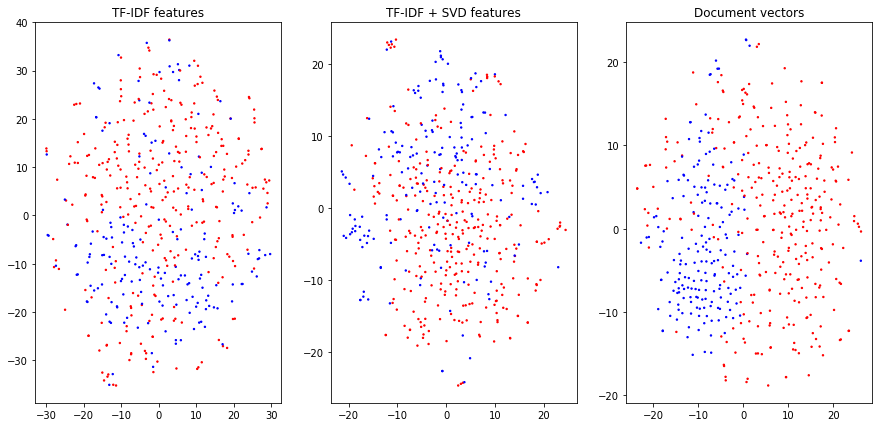

In [16]:
cluster_labels_cut = cluster_labels[0:size]
cluster_colours = ['b' if label==1 else 'r' for label in cluster_labels_cut]

rcParams['lines.markersize']=1.4
rcParams['figure.figsize']=(15,7)

plt.subplot(1, 3, 1)
plt.title("TF-IDF features")
plt.scatter(Xt_tfidf[:,0], Xt_tfidf[:,1], c=cluster_colours)

plt.subplot(1, 3, 2)
plt.title("TF-IDF + SVD features")
plt.scatter(Xt_reduce[:,0], Xt_reduce[:,1], c=cluster_colours)

plt.subplot(1, 3, 3)
plt.title("Document vectors")
plt.scatter(Xt_docvecs[:,0], Xt_docvecs[:,1], c=cluster_colours)

plt.show()

### Word clouds

Visualising the clusters suggests that close together points have been put into the same cluster; however, it is unclear what each cluster represents or whether these clusters are sensible.

Unfortunately, the use of document vectors means the cluster centres are hard to interprupt. One thing we can do is to plot a word cloud for each of these clusters.

Word cloud for cluster: 0


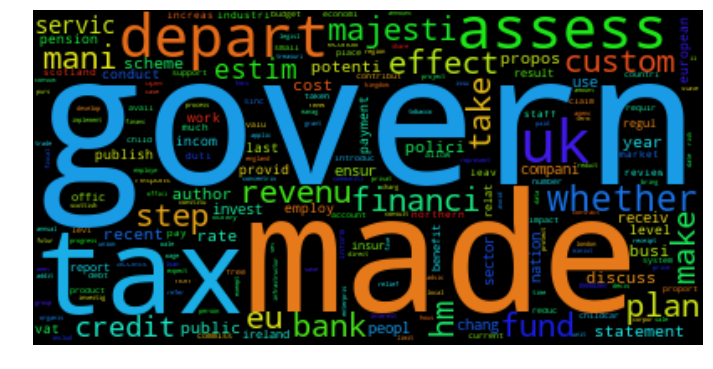

Word cloud for cluster: 1


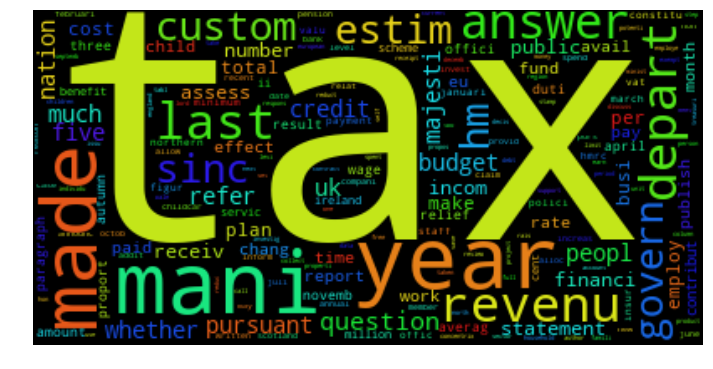

In [17]:

df['cluster'] = cluster_labels


def wc_cluster(cluster):
    
    print "Word cloud for cluster:", cluster
    
    # Combined the tokens back into whole strings
    cleaned_strings = df[df['cluster']==cluster]['tokens'].apply(lambda x: ' '.join(x)).tolist()

    # Join the strings together
    combined_text = ' '.join(cleaned_strings)

    # Display a word cloud
    wc = WordCloud(random_state=42).generate( combined_text )
    plt.figure(figsize=(12,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()    

wc_cluster(0)
wc_cluster(1)